<a href="https://colab.research.google.com/github/somyayadav14/HR-Attrition-Analysis/blob/main/HR_Attrition_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score

#Load Dataset

In [3]:
df = pd.read_csv("/content/employee_attrition_data.csv")
df



,EmployeeID,Department,JobRole,Age,Gender,MonthlySalary,ExperienceYears,PerformanceRating,Attrition
0,1001,IT,Software Engineer,26,F,35000,2,3,Yes
1,1002,HR,HR Executive,29,M,28000,4,4,No
2,1003,Finance,Analyst,35,F,55000,9,3,Yes
3,1004,IT,Data Analyst,31,M,48000,6,4,No
4,1005,Sales,Sales Executive,27,F,30000,3,2,Yes
5,1006,Sales,Manager,41,M,75000,15,4,No
6,1007,IT,Software Engineer,24,M,32000,1,2,Yes
7,1008,Finance,Manager,45,F,82000,20,5,No
8,1009,HR,Recruiter,28,F,29000,4,3,Yes
9,1010,IT,Data Scientist,34,M,68000,8,4,No


In [4]:
# First 5 rows
print(df.head())

   EmployeeID Department            JobRole  Age Gender  MonthlySalary  \
0        1001         IT  Software Engineer   26      F          35000   
1        1002         HR       HR Executive   29      M          28000   
2        1003    Finance            Analyst   35      F          55000   
3        1004         IT       Data Analyst   31      M          48000   
4        1005      Sales    Sales Executive   27      F          30000   

   ExperienceYears  PerformanceRating Attrition  
0                2                  3       Yes  
1                4                  4        No  
2                9                  3       Yes  
3                6                  4        No  
4                3                  2       Yes  


In [5]:
print(df.shape)

(10, 9)


In [6]:
print(df.columns)

Index(['EmployeeID', 'Department', 'JobRole', 'Age', 'Gender', 'MonthlySalary',
       'ExperienceYears', 'PerformanceRating', 'Attrition'],
      dtype='object')


In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   EmployeeID         10 non-null     int64 
 1   Department         10 non-null     object
 2   JobRole            10 non-null     object
 3   Age                10 non-null     int64 
 4   Gender             10 non-null     object
 5   MonthlySalary      10 non-null     int64 
 6   ExperienceYears    10 non-null     int64 
 7   PerformanceRating  10 non-null     int64 
 8   Attrition          10 non-null     object
dtypes: int64(5), object(4)
memory usage: 852.0+ bytes
None


In [8]:
print(df.isnull().sum())

EmployeeID           0
Department           0
JobRole              0
Age                  0
Gender               0
MonthlySalary        0
ExperienceYears      0
PerformanceRating    0
Attrition            0
dtype: int64


In [11]:
# Count duplicate rows
duplicate_counts = df.duplicated().sum()

# Display the number of duplicate rows
print(f"Number of Duplicate Rows: {duplicate_counts}")

Number of Duplicate Rows: 0


In [12]:
df.describe()

,EmployeeID,Age,MonthlySalary,ExperienceYears,PerformanceRating
count,10.00000,10.00000,10.00000,10.00000,10.000000
mean,1005.50000,32.00000,48200.00000,7.20000,3.400000
std,3.02765,6.78233,20665.59137,6.08824,0.966092
min,1001.00000,24.00000,28000.00000,1.00000,2.000000
25%,1003.25000,27.25000,30500.00000,3.25000,3.000000
50%,1005.50000,30.00000,41500.00000,5.00000,3.500000
75%,1007.75000,34.75000,64750.00000,8.75000,4.000000
max,1010.00000,45.00000,82000.00000,20.00000,5.000000


#Overall Attrition Rate (KPI)

In [9]:
total_employees = len(df)
attrition_count = df[df['Attrition'] == 'Yes'].shape[0]
attrition_rate = (attrition_count / total_employees) * 100

print("Total Employees:", total_employees)
print("Employees Left:", attrition_count)
print("Attrition Rate (%):", round(attrition_rate, 2))


Total Employees: 10
Employees Left: 5
Attrition Rate (%): 50.0


#Attrition by Department

In [10]:
dept_attrition = (
    df.groupby('Department')['Attrition']
      .value_counts()
      .unstack()
      .fillna(0)
)

print(dept_attrition)


Attrition   No  Yes
Department         
Finance      1    1
HR           1    1
IT           2    2
Sales        1    1


#Visualization

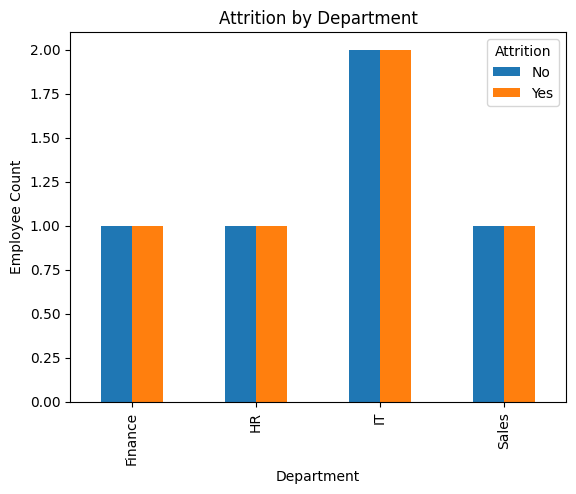

In [17]:
dept_attrition.plot(kind='bar')
plt.title("Attrition by Department")
plt.xlabel("Department")
plt.ylabel("Employee Count")
plt.show()


In [18]:
# Create a subset of the DataFrame with 'Attrition' and 'Gender' columns
attrition_gender_data = df[['Attrition', 'Gender']]

# Create a cross-tabulation (crosstab) of Attrition and Gender
attrition_by_gender = pd.crosstab(attrition_gender_data['Attrition'], attrition_gender_data['Gender'])

# Display the cross-tabulation
print(attrition_by_gender)

Gender     F  M
Attrition      
No         1  4
Yes        4  1


In [19]:
import scipy.stats as stats

# Create a contingency table from the cross-tabulation
contingency_table = pd.crosstab(attrition_gender_data['Attrition'], attrition_gender_data['Gender'])

# Perform the chi-squared test
chi2, p, _, _ = stats.chi2_contingency(contingency_table)

# Display the test statistics and p-value
print(f"Chi-squared value: {chi2}")
print(f"P-value: {p}")

# Determine the significance level
alpha = 0.05

# Check if the p-value is less than the significance level
if p < alpha:
    print("The difference in attrition rates between genders is statistically significant.")
else:
    print("There is no statistically significant difference in attrition rates between genders.")

Chi-squared value: 1.6
P-value: 0.20590321073206466
There is no statistically significant difference in attrition rates between genders.


In [46]:
import plotly.express as px

# Create a bar chart showing attrition counts by gender
fig = px.bar(contingency_table, x=contingency_table.columns, y=contingency_table.index, title="Attrition by Gender")
fig.update_layout(xaxis_title="Count", yaxis_title="Attrition")
fig.update_traces(marker_color=["blue", "Orange"])

# Annotate the p-value from the chi-squared test
fig.add_annotation(
    text=f"P-value: {p:.4f}",
    xref="paper", yref="paper",
    x=0.8, y=0.2,
    showarrow=False,
    font=dict(size=14, color="red")
)

# Show the plot
fig.show()


#Salary Band vs Attrition

Create Salary Band

In [21]:
def salary_band(salary):
    if salary < 40000:
        return "Low Salary"
    elif salary <= 70000:
        return "Medium Salary"
    else:
        return "High Salary"

df['SalaryBand'] = df['MonthlySalary'].apply(salary_band)


Analysis

In [22]:
salary_attrition = (
    df.groupby('SalaryBand')['Attrition']
      .value_counts()
      .unstack()
      .fillna(0)
)

print(salary_attrition)


Attrition       No  Yes
SalaryBand             
High Salary    2.0  0.0
Low Salary     1.0  4.0
Medium Salary  2.0  1.0


#Experience Impact on Attrition

In [23]:
exp_attrition = (
    df.groupby('ExperienceYears')['Attrition']
      .value_counts(normalize=True)
      .unstack()
      .fillna(0) * 100
)

print(exp_attrition)


Attrition           No    Yes
ExperienceYears              
1                  0.0  100.0
2                  0.0  100.0
3                  0.0  100.0
4                 50.0   50.0
6                100.0    0.0
8                100.0    0.0
9                  0.0  100.0
15               100.0    0.0
20               100.0    0.0


In [25]:
correlation_matrix = df.select_dtypes(include=['number']).corr()

# Find pairs of columns with correlation greater than 0.5
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.5:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

# List pairs with correlation greater than 0.5
for pair in high_corr_pairs:
    col1, col2, corr = pair
    print(f"Correlation between {col1} and {col2}: {corr:.2f}")

Correlation between Age and MonthlySalary: 0.93
Correlation between Age and ExperienceYears: 0.99
Correlation between Age and PerformanceRating: 0.78
Correlation between MonthlySalary and ExperienceYears: 0.92
Correlation between MonthlySalary and PerformanceRating: 0.71
Correlation between ExperienceYears and PerformanceRating: 0.76


#Performance Rating vs Attrition

In [26]:
perf_attrition = (
    df.groupby('PerformanceRating')['Attrition']
      .value_counts()
      .unstack()
      .fillna(0)
)

print(perf_attrition)


Attrition           No  Yes
PerformanceRating          
2                  0.0  2.0
3                  0.0  3.0
4                  4.0  0.0
5                  1.0  0.0


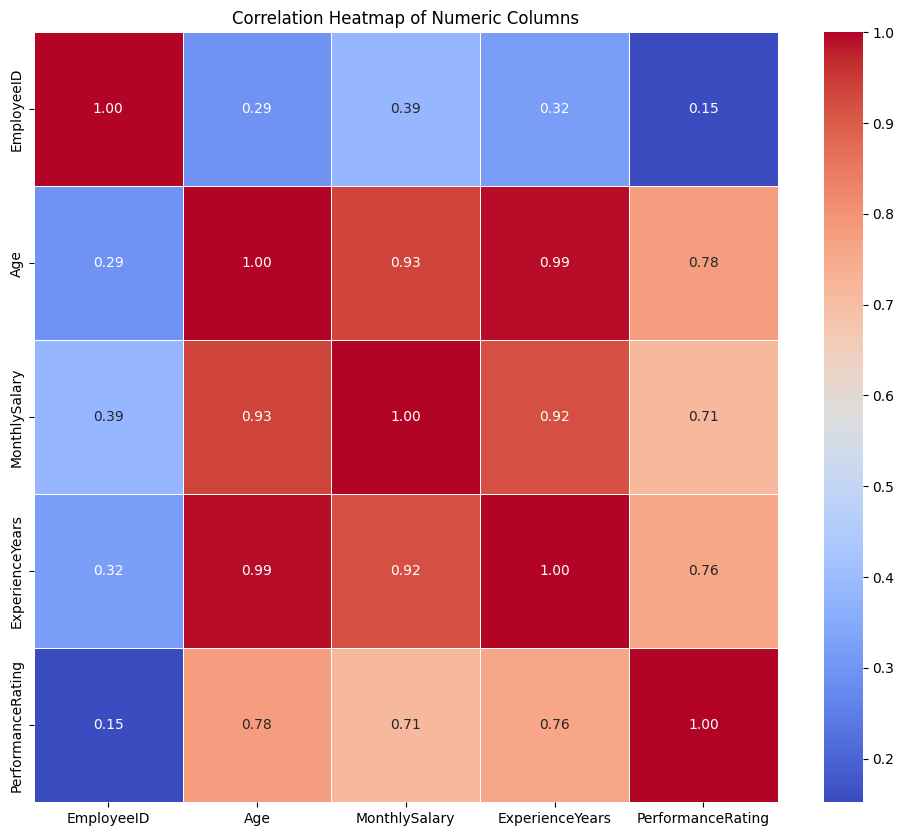

In [28]:
import seaborn as sns

# Get all numeric columns from the DataFrame for correlation analysis
important_data = df.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = important_data.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap of Numeric Columns")
plt.show()

In [30]:
import plotly.express as px

# Create a cross-tabulation of Attrition and JobRole (or any other categorical column)
attrition_by_jobrole = pd.crosstab(df['Attrition'], df['JobRole'])

# Reset the index to make it easier to work with Plotly
attrition_by_jobrole = attrition_by_jobrole.reset_index()

# Melt the data for plotting
attrition_by_jobrole_melted = attrition_by_jobrole.melt(id_vars='Attrition')

# Create a bar plot to visualize attrition by JobRole using Plotly
fig = px.bar(attrition_by_jobrole_melted, x='Attrition', y='value', color='JobRole',
             labels={'Attrition': 'Attrition', 'value': 'Count', 'JobRole': 'JobRole'},
             title="Attrition by JobRole")

fig.show()

In [32]:
import scipy.stats as stats

# Create a cross-tabulation of Attrition and Gender (instead of Overtime)
attrition_by_gender_for_chi2 = pd.crosstab(df['Attrition'], df['Gender'])

# Perform the chi-squared test
chi2, p, _, _ = stats.chi2_contingency(attrition_by_gender_for_chi2)

# Display the test statistics and p-value
print(f"Chi-squared value: {chi2}")
print(f"P-value: {p}")

# Determine the significance level
alpha = 0.05

# Check if the p-value is less than the significance level
if p < alpha:
    print("The relationship between Attrition and Gender is statistically significant.")
else:
    print("There is no statistically significant relationship between Attrition and Gender.")
# Visualize the relationship between Attrition and Gender using a bar chart
import plotly.express as px

# Create a bar plot to visualize the relationship
attrition_by_gender_for_chi2 = attrition_by_gender_for_chi2.reset_index()
fig = px.bar(attrition_by_gender_for_chi2, x='Attrition', y=['F', 'M'], title="Attrition by Gender",
             labels={'Attrition': 'Attrition', 'value': 'Count', 'variable': 'Gender'},
             barmode='group')

fig.show()

Chi-squared value: 1.6
P-value: 0.20590321073206466
There is no statistically significant relationship between Attrition and Gender.


<Axes: xlabel='Department', ylabel='count'>

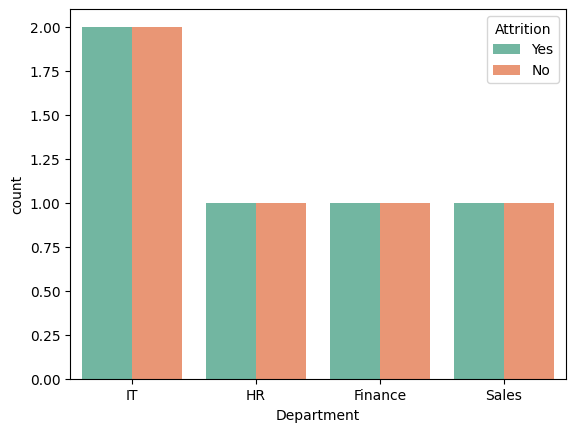

In [33]:
sns.countplot(data=df, x='Department', hue='Attrition', palette='Set2')

In [34]:
import plotly.graph_objects as go

# Calculate counts of Attrition by Department
attrition_counts = df.groupby(['Department', 'Attrition']).size().unstack(fill_value=0)

# Create a grouped bar chart
fig = go.Figure(data=[
    go.Bar(name='No', x=attrition_counts.index, y=attrition_counts['No']),
    go.Bar(name='Yes', x=attrition_counts.index, y=attrition_counts['Yes'])
])

# Set layout for the chart
fig.update_layout(barmode='group', title='Attrition by Department', xaxis_title='Department', yaxis_title='Count')

# Show the chart
fig.show()

In [36]:
# Create a KDE plot in Plotly Express
fig = px.histogram(df, x='ExperienceYears', color='Attrition', marginal='rug', opacity=0.7,
                   histnorm='probability density', barmode='overlay')

# Set the chart title and labels
fig.update_layout(title='KDE Plot of ExperienceYears by Attrition', xaxis_title='Experience Years', yaxis_title='Density')

# Show the chart
fig.show()

In [38]:
import plotly.graph_objects as go

# Group the data by Department and Attrition and calculate the count
attrition_counts = df.groupby(['Department', 'Attrition']).size().reset_index(name='Count')

# Create a bar chart
fig = go.Figure(data=[
    go.Bar(name='Yes', x=attrition_counts[attrition_counts['Attrition'] == 'Yes']['Department'], y=attrition_counts[attrition_counts['Attrition'] == 'Yes']['Count']),
    go.Bar(name='No', x=attrition_counts[attrition_counts['Attrition'] == 'No']['Department'], y=attrition_counts[attrition_counts['Attrition'] == 'No']['Count'])
])

# Set the layout for the chart
fig.update_layout(barmode='group', title='Attrition by Department', xaxis_title='Department', yaxis_title='Count')

# Show the chart
fig.show()

In [39]:
import plotly.graph_objects as go

# Group the data by JobRole and Attrition and calculate the count
attrition_counts = df.groupby(['JobRole', 'Attrition']).size().reset_index(name='Count')

# Create a bar chart
fig = go.Figure(data=[
    go.Bar(name='Yes', x=attrition_counts[attrition_counts['Attrition'] == 'Yes']['JobRole'], y=attrition_counts[attrition_counts['Attrition'] == 'Yes']['Count']),
    go.Bar(name='No', x=attrition_counts[attrition_counts['Attrition'] == 'No']['JobRole'], y=attrition_counts[attrition_counts['Attrition'] == 'No']['Count'])
])

# Set the layout for the chart
fig.update_layout(barmode='group', title='Attrition by Job Role', xaxis_title='Job Role', yaxis_title='Count')

# Rotate the x-axis labels for better readability (optional)
fig.update_xaxes(tickangle=90)

# Show the chart
fig.show()

In [42]:
import plotly.graph_objects as go

# Group the data by Department and Attrition and calculate the count
attrition_counts = df.groupby(['Department', 'Attrition']).size().reset_index(name='Count')

# Calculate the total counts for each Department
total_counts = df.groupby('Department').size().reset_index(name='TotalCount')

# Merge the two DataFrames to calculate the ratio
attrition_counts = attrition_counts.merge(total_counts, on='Department')
attrition_counts['Ratio'] = attrition_counts['Count'] / attrition_counts['TotalCount']

# Create a stacked bar chart
fig = go.Figure()

for attrition in ['Yes', 'No']:
    data = attrition_counts[attrition_counts['Attrition'] == attrition]
    fig.add_trace(go.Bar(
        name=attrition,
        x=data['Department'],
        y=data['Count'],
        hovertext=data['Ratio'].map('{:.2%}'.format)
    ))

# Set the layout for the chart
fig.update_layout(barmode='relative', title='Attrition by Department', xaxis_title='Department', yaxis_title='Count')

# Show the chart
fig.show()

In [44]:
import plotly.express as px

# Group the data by Age, Gender, and count the occurrences
overtime_counts = df.groupby(['Age', 'Gender']).size().reset_index(name='Count')

# Create a line chart
fig = px.line(overtime_counts, x='Age', y='Count', color='Gender',
              title='Relation between Gender and Age',
              labels={'Age': 'Age', 'Count': 'Count', 'Gender': 'Gender'},
              category_orders={"Gender": ['F', 'M']})

# Show the chart
fig.show()